In [1]:
import numpy as np
import scipy

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

import sklearn

import skopt

/opt/miniconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
### http://g.sweyla.com/blog/2012/mnist-numpy/
import mnist

In [3]:
%%sh

mkdir -p mnist && {
    cd mnist;
    wget -q -nc http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz &&
    gunzip *.gz
}

gzip: t10k-images-idx3-ubyte already exists;	not overwritten
gzip: t10k-labels-idx1-ubyte already exists;	not overwritten
gzip: train-images-idx3-ubyte already exists;	not overwritten
gzip: train-labels-idx1-ubyte already exists;	not overwritten


In [4]:
X_original, y = mnist.load_mnist(dataset='training', path='mnist/')
X_original = X_original.reshape(-1, 28, 28).astype('float32')

X_original_test, y_test = mnist.load_mnist(dataset='testing', path='mnist/')
X_original_test = X_original_test.reshape(-1, 28, 28).astype('float32')

In [5]:
from scipy.misc import imresize

In [6]:
def rescale(X, target=(8, 8)):
    X_new = np.ndarray(shape=X.shape[:1] + target, dtype='float32')
    for i in tqdm_notebook(range(X.shape[0]), total=X.shape[0]):
        X_new[i] = imresize(X[i], target, interp='lanczos')
    
    return X_new

In [7]:
X = rescale(X_original)

A Jupyter Widget

In [8]:
X_test = rescale(X_original_test)

A Jupyter Widget

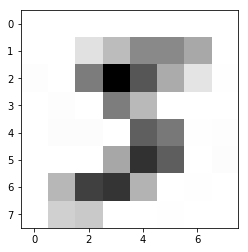

In [9]:
plt.imshow(X[0], cmap=plt.cm.gray_r)

In [10]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.9)

For some reason we wish to find a fast and accurate model, using following objective function:
    $$1 - \mathrm{accuracy} + \frac{\mathrm{n\;trees}}{1000} \to \min$$

In [12]:
def objective(n):
    """
    This objective balances performance and accuracy
    """
    ### input value is a list of float parameters
    n = int(np.exp(n[0]))
    boost = ExtraTreesClassifier(n_estimators=n, max_depth=25, n_jobs=-1)
    boost.fit(X_train.reshape(-1, 64), y_train)
    proba = boost.predict(X_val.reshape(-1, 64))
    return 1.0 - accuracy_score(y_val, proba) + n / 1000.0 

In [13]:
%%time

objective([np.log(999)])

CPU times: user 54.2 s, sys: 11.3 s, total: 1min 5s
Wall time: 16.3 s


1.0530925925925927

In [14]:
from skopt import gp_minimize

res = gp_minimize(objective,
                  [(1, np.log(1000))],
                  acq_func="EI",
                  n_calls=20,
                  n_random_starts=5,
                  random_state=123,
                  noise=1.0e-3)

In [15]:
len(res.models)

15

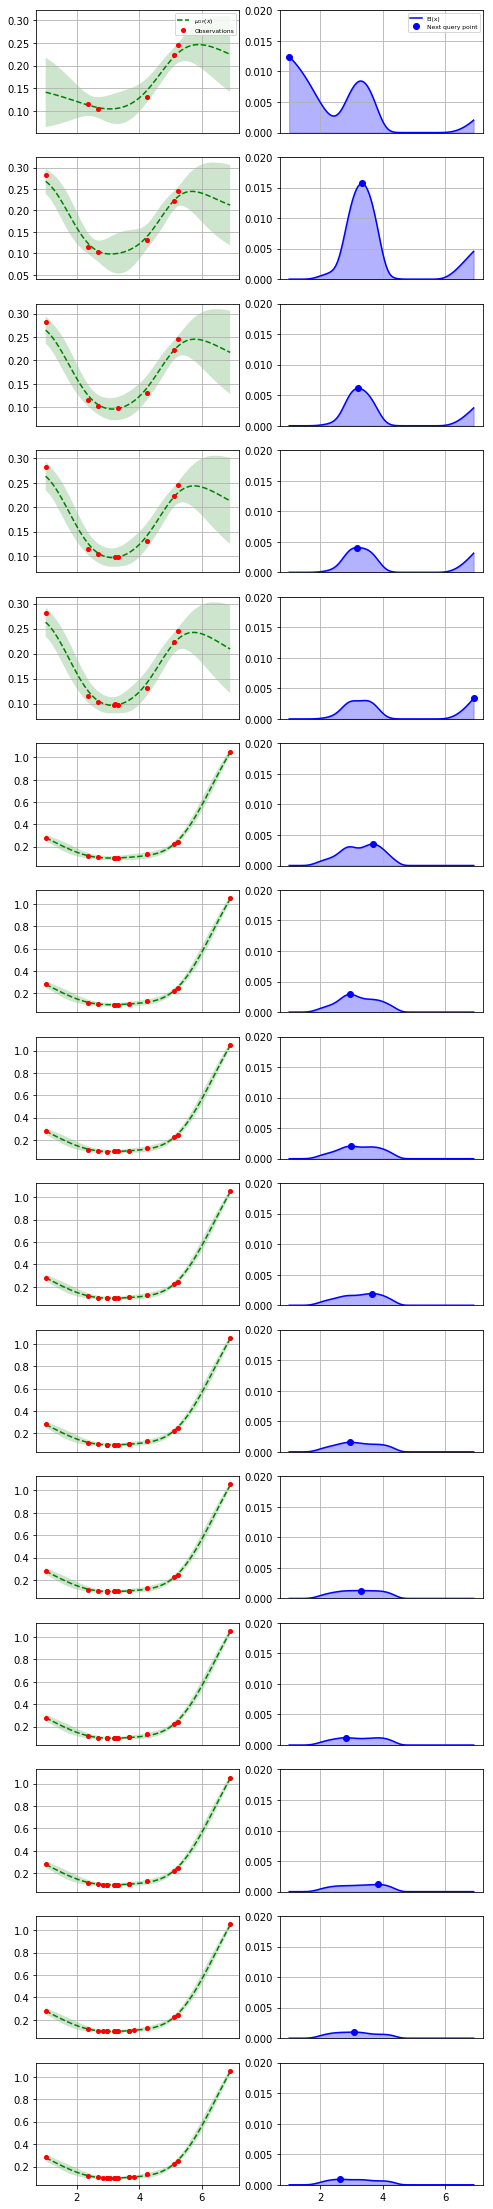

In [16]:
from skopt.acquisition import gaussian_ei

f = objective

plt.rcParams["figure.figsize"] = (8, 40)

x = np.linspace(1, np.log(1000), 100).reshape(-1, 1)
x_gp = res.space.transform(x.tolist())

step = 1
nrows= 15

for n_iter in range(nrows):
    gp = res.models[step * n_iter]
    curr_x_iters = res.x_iters[:5+step * n_iter]
    curr_func_vals = res.func_vals[:5+step * n_iter]

    # Plot true function.
    plt.subplot(nrows, 2, 2*n_iter+1)

    # Plot GP(x) + contours
    y_pred, sigma = gp.predict(x_gp, return_std=True)
    plt.plot(x, y_pred, "g--", label=r"$\mu_{GP}(x)$")
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - sigma, 
                             (y_pred +  sigma)[::-1]]),
             alpha=.2, fc="g", ec="None")

    # Plot sampled points
    plt.plot(curr_x_iters, curr_func_vals,
             "r.", markersize=8, label="Observations")

    # Adjust plot layout
    plt.grid()

    if n_iter == 0:
        plt.legend(loc="best", prop={'size': 6}, numpoints=1)

    if n_iter != nrows - 1:
        plt.tick_params(axis='x', which='both', bottom='off', 
                        top='off', labelbottom='off') 

    # Plot EI(x)
    plt.subplot(nrows, 2, 2*n_iter+2)
    acq = gaussian_ei(x_gp, gp, y_opt=np.min(curr_func_vals))
    plt.plot(x, acq, "b", label="EI(x)")
    plt.fill_between(x.ravel(), 0.0, acq.ravel(), alpha=0.3, color='blue')

    next_x = res.x_iters[5 + step * n_iter]
    next_acq = gaussian_ei(res.space.transform([next_x]), gp, y_opt=np.min(curr_func_vals))
    plt.plot(next_x, next_acq, "bo", markersize=6, label="Next query point")

    # Adjust plot layout
    plt.ylim(0, 0.02)
    plt.grid()

    if n_iter == 0:
        plt.legend(loc="best", prop={'size': 6}, numpoints=1)

    if n_iter != nrows - 1:
        plt.tick_params(axis='x', which='both', bottom='off', 
                        top='off', labelbottom='off') 

plt.show()

In [17]:
print('Optimal number of trees: %d' % int(np.exp(res.x)))

Optimal number of trees: 27


In [18]:
print('Accuracy: %.2lf' % (1 - (res.fun - np.exp(res.x) / 1000)))

Accuracy: 0.93
